# West Nile Virus prediction

### Import libraries

In [300]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.utils import resample

from sklearn.cluster import DBSCAN

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense

sns.set_style("darkgrid")

### Load Data

In [301]:
train = pd.read_csv("data/train.csv")
wx = pd.read_csv("data/weather.csv")
spray = pd.read_csv("data/spray.csv")
se = pd.read_csv("data/socioecon.csv")

ss = pd.read_csv("data/sampleSubmission.csv")
test = pd.read_csv("data/test.csv")

### Exploratory Data Analysis, Cleaning

In [302]:
se.drop(columns=['COMMUNITY AREA NAME'], inplace=True)

In [303]:
se.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Lat,Lon
0,1.0,7.7,23.6,8.7,18.2,27.5,23939,39.0,42.010636,-87.669553
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0,42.000580,-87.692577
2,3.0,3.8,24.0,8.9,11.8,22.2,35787,20.0,41.966540,-87.653340
3,4.0,3.4,10.9,8.2,13.4,25.5,37524,17.0,41.969948,-87.688678
4,5.0,0.3,7.5,5.2,4.5,26.2,57123,6.0,41.950892,-87.682768


In [304]:
# # get list of community area names to call geocoder
# comm = [i for i in se['COMMUNITY AREA NAME']]
# communities = [i + ', Chicago, Illinois' for i in comm]

In [305]:
se.tail(10)

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Lat,Lon
68,69.0,3.6,29.6,23.0,16.5,41.0,17285,66.0,41.763414,-87.595383
69,70.0,4.0,10.4,11.7,17.7,36.9,23482,37.0,41.747900,-87.707218
70,71.0,4.0,27.6,28.3,18.5,41.9,15528,74.0,41.743377,-87.656200
71,72.0,0.9,5.1,8.0,3.7,40.5,39523,12.0,41.717120,-87.676180
72,73.0,1.1,16.9,20.8,13.7,42.6,19713,48.0,41.715964,-87.650631
73,74.0,1.0,3.4,8.7,4.3,36.8,34381,16.0,41.693122,-87.712355
74,75.0,0.8,13.2,15.0,10.8,40.3,27149,30.0,41.687840,-87.669003
75,76.0,3.6,15.4,7.1,10.9,30.3,25828,24.0,41.977298,-87.836891
76,77.0,4.1,18.2,9.2,9.7,23.8,33385,19.0,41.987245,-87.661233
77,NaN,4.7,19.7,12.9,19.5,33.5,28202,NaN,NaN,NaN


In [306]:
len(train['Block'].unique())

64

In [307]:
len(train['Trap'].unique())

136

In [308]:
train['Date'] = pd.to_datetime(train['Date'])

In [309]:
spray['Date'] = pd.to_datetime(spray['Date'])
spray['am_pm'] = spray['Time'].apply(lambda x: str(x).split()[-1])
spray['Time'] = spray['Time'].apply(lambda x: str(x).split()[0])

# spray['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [310]:
#converting Weather columns to datetime
wx['Date'] = pd.to_datetime(wx['Date'])

In [311]:
wx.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [313]:
wx_sm = wx[['Date', 'Station', 'Tavg', 'WetBulb', 'StnPressure', 'DewPoint']].copy()

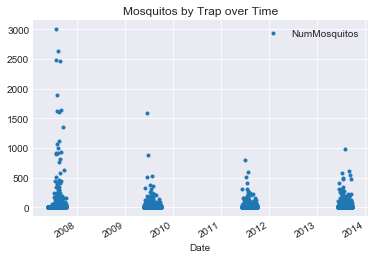

In [314]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time');

In [315]:
wx.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


### Feature Engineering

#### Find closest Wx station

In [316]:
from haversine import haversine

#### It looks like a trap moved, or has two different locations:

In [317]:
len(train.Latitude.unique())

138

In [318]:
len(train.Trap.unique())

136

#### Explore trap locations in the context of nearest weather station

In [319]:
traps = train[['Trap', 'Latitude', 'Longitude']].drop_duplicates(['Trap']).reset_index(drop=True)

In [320]:
locations = []
for i in range(len(traps)):
    locations.append((traps['Latitude'][i], traps['Longitude'][i]))

In [321]:
ll = pd.Series(locations)
traps['Location'] = ll.values

In [322]:
traps.head()

,Trap,Latitude,Longitude,Location
0,T002,41.954690,-87.800991,"(41.95469, -87.800991)"
1,T007,41.994991,-87.769279,"(41.994991, -87.769279)"
2,T015,41.974089,-87.824812,"(41.974089, -87.824812)"
3,T045,41.921600,-87.666455,"(41.9216, -87.666455)"
4,T046,41.891118,-87.654491,"(41.891118, -87.654491)"


In [323]:
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
st1 = (41.995, -87.933)

# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
st2 = (41.786, -87.752)

In [324]:
my_list = []
for location in locations:
    if haversine(st2, location) < haversine(st1, location):
        my_list.append(2)
    else:
        my_list.append(1)

print('# of st1:', my_list.count(1))
print('# of st2:', my_list.count(2))

# of st1: 39
# of st2: 97


In [325]:
import math

#initialize variables
radius = 6371 #km

# custom Great Circle Distance (haversine) function
def GCD(lat1,lon1,lat2,lon2):
    #code goes here
    sin1 = math.sin(math.radians(lat1))
    sin2 = math.sin(math.radians(lat2))
    cos1 = math.cos(math.radians(lat1))
    cos2 = math.cos(math.radians(lat2))
    dellon = math.cos(abs(math.radians(lon2-lon1)))
    
    delsigma = math.acos(sin1*sin2 + cos1*cos2*dellon)

    d = radius*delsigma
    return d

In [326]:
# Wx station 1 coordinates
lat1 = 41.995
lat2 = 41.786

# Wx station 2 coordinates
lon1 = -87.933
lon2 = -87.752

In [327]:
# calculate distance between trap and each Wx station
# assign trap to appropriate station (closest)

train['Station'] = 1

for i in range(train.shape[0]):
    if GCD(lat1, lon1, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']) > GCD(lat2, lon2, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']):
        train.loc[i,'Station'] = 2

In [328]:
# verify results
train['Station'].unique()

array([1, 2])

### Merge Wx data on to train data

In [329]:
train = train.merge(wx_sm, how = 'left', on = ['Date','Station'])

In [330]:
# verify merge on Wx stations
train.groupby(by ='Station')['Station'].count()

Station
1    3298
2    7208
Name: Station, dtype: int64

In [331]:
# drop variables not needed for predicting WNV
train.drop(columns=['AddressAccuracy','AddressNumberAndStreet', 'Block', 'Street', 
                    'Address', 'Station', 'Latitude', 'Longitude', 'NumMosquitos'], inplace=True)

### Get dummies for unique mosquito species

In [336]:
# separate week, month, and year
train['Week'] = train['Date'].dt.week

# drop date column
train.drop(columns = ['Date', 'Species'], inplace= True)

#get dummies
train = pd.get_dummies(train, columns = ['Week', 'Trap'])

# Modeling

In [337]:
# Baseline accuracy is 94.76%
format(1 - train['WnvPresent'].sum()/train.shape[0], '.5f')

'0.94755'

In [338]:
# independent variables/ features to predict presence of WNV
X = train.drop(columns = 'WnvPresent')
# target
y = train['WnvPresent']

In [339]:
# split training and test data (70-30) 
# random state=42 for reproducability
# stratify on WNV to balance classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=train['WnvPresent'])

In [340]:
# #rejoin train data on index so it can be downsampled to match classes
# traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)

# #separate minority and majority classes
# train_majority = traindata[traindata['WnvPresent'] == 0]
# train_minority = traindata[traindata['WnvPresent'] == 1]

# #upsample minority class
# train_minority_upsampled = resample(train_minority, 
#                                      replace = True, 
#                                      n_samples = train_majority.shape[0],
#                                      random_state = 65)
# #combine classes
# train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
# #split back into X_train and y_train
# X_train = train_data_upsampled.drop(columns = 'WnvPresent')
# y_train = train_data_upsampled['WnvPresent']

In [341]:
# standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

ValueError: could not convert string to float: 'M'

In [52]:
# create neural network
model = Sequential()

input_units = X_train.shape[1]
hidden_units = round(input_units)

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu'))

model.add(Dense(82, activation = 'relu'))

model.add(Dense(41, activation = 'relu'))

model.add(Dense(20, activation = 'relu'))

model.add(Dense(10, activation = 'relu'))

model.add(Dense(5, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [63]:
train.info

<bound method DataFrame.info of        WnvPresent Tavg  Week_22  Week_23  Week_24  Week_25  Week_26  Week_27  \
0               0   74        1        0        0        0        0        0   
1               0   74        1        0        0        0        0        0   
2               0   74        1        0        0        0        0        0   
3               0   74        1        0        0        0        0        0   
4               0   74        1        0        0        0        0        0   
5               0   77        1        0        0        0        0        0   
6               0   77        1        0        0        0        0        0   
7               0   77        1        0        0        0        0        0   
8               0   77        1        0        0        0        0        0   
9               0   77        1        0        0        0        0        0   
10              0   77        1        0        0        0        0        0   
11      

In [54]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs=10, 
                   batch_size=None, 
                   verbose=1)

Train on 8404 samples, validate on 2102 samples
Epoch 1/10
8404/8404 [==============================] - 1s 134us/step - loss: 0.2020 - binary_accuracy: 0.9475 - val_loss: 0.1841 - val_binary_accuracy: 0.9477
Epoch 2/10
8404/8404 [==============================] - 0s 57us/step - loss: 0.1695 - binary_accuracy: 0.9475 - val_loss: 0.1895 - val_binary_accuracy: 0.9477
Epoch 3/10
8404/8404 [==============================] - 0s 57us/step - loss: 0.1620 - binary_accuracy: 0.9475 - val_loss: 0.1909 - val_binary_accuracy: 0.9477
Epoch 4/10
8404/8404 [==============================] - 0s 56us/step - loss: 0.1568 - binary_accuracy: 0.9475 - val_loss: 0.1986 - val_binary_accuracy: 0.9477
Epoch 5/10
8404/8404 [==============================] - 0s 57us/step - loss: 0.1540 - binary_accuracy: 0.9475 - val_loss: 0.1873 - val_binary_accuracy: 0.9477
Epoch 6/10
8404/8404 [==============================] - 0s 57us/step - loss: 0.1489 - binary_accuracy: 0.9475 - val_loss: 0.1943 - val_binary_accuracy: 0.94

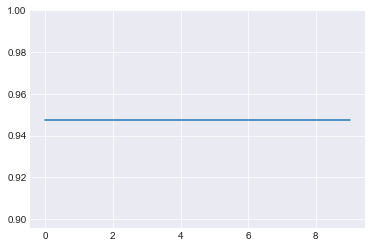

In [55]:
plt.plot(history.history['val_binary_accuracy'])

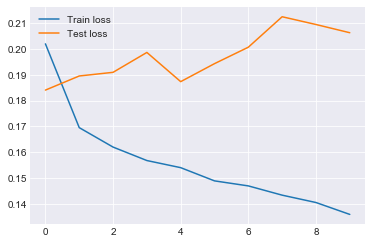

In [56]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend()

In [57]:
# confusion matrix, roc
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
roc_auc

0.77773822562979189

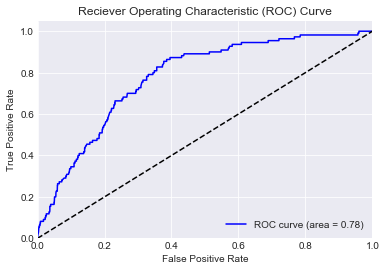

In [58]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [59]:
# XGBoost model
model = xgb.XGBClassifier(seed=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv=5, n_jobs =-1)

In [60]:
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.669649	validation_1-auc:0.619674
[1]	validation_0-auc:0.669649	validation_1-auc:0.619674
[2]	validation_0-auc:0.696535	validation_1-auc:0.657886
[3]	validation_0-auc:0.697658	validation_1-auc:0.658755
[4]	validation_0-auc:0.734642	validation_1-auc:0.698624
[5]	validation_0-auc:0.73553	validation_1-auc:0.698711
[6]	validation_0-auc:0.736552	validation_1-auc:0.701228
[7]	validation_0-auc:0.735447	validation_1-auc:0.699379
[8]	validation_0-auc:0.73545	validation_1-auc:0.699379
[9]	validation_0-auc:0.746873	validation_1-auc:0.708434
[10]	validation_0-auc:0.747492	validation_1-auc:0.709022
[11]	validation_0-auc:0.748464	validation_1-auc:0.710442
[12]	validation_0-auc:0.748361	validation_1-auc:0.710989
[13]	validation_0-auc:0.750823	validation_1-auc:0.711181
[14]	validation_0-auc:0.76265	validation_1-auc:0.723056
[15]	validation_0-auc:0.763314	validation_1-auc:0.723325
[16]	validation_0-auc:0.779156	validation_1-auc:0.738693
[17]	validation_0-auc:0.781988	validation_1-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [61]:
model.score(X_test, y_test)

0.94766888677450045

In [62]:
# kaggle submission
submission = pd.DataFrame(model.predict_proba(test), columns=['WnvPresent'])
    
submission.set_index(np.arange(1, test.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('~/Desktop/Git_lessons/Project4/westnilevirussubmission.csv', index=False)

NameError: name 'test' is not defined